# TensorFlow Serving in 10 minutes!

TensorFlow **SERVING** is Googles' recommended way to deploy TensorFlow models. Without proper computer engineering background, it can be quite intimidating, even for people who feel comfortable with TensorFlow itself. Few things that I've found particularly hard were:
- Tutorial examples have C++ code (which I don't know)
- Tutorials have Kubernetes, gRPG, Bezel (some of which I saw for the first time)
- It needs to be compiled. That process takes forever!

After all, it worked just fine. Here I present an easiest possible way to deploy your models with TensorFlow Serving. You will have your self-built model running inside TF-Serving by the end of this tutorial. It will be scalable, and you will be able to query it via REST.

The Tutorial uses the Docker image. You can use Kitematic to start the image: **`avloss/tensorflow-serving-rest`**.

*At first, I tried building it on "DockerHub" - but it hit the limit of 2 hours, so I had to use https://quay.io. I've uploaded finished result to DockerHub manually, but please feel free to pull from https://quay.io/repository/avloss/tensorflow-serving-rest in case you want to make sure it's what's it says it is.*

You can start Docker Container from Kitematic, or use this command from console:

`docker run --rm -it -p 8888:8888 -p 9000:9000 -p 8915:8915  quay.io/avloss/tensorflow-serving-rest`

Once it's running, please navigate to http://localhost:8888/notebooks/tf_serving_rest_example.ipynb. (Use different port if using Kitematic)

**From here it's best to continue from within Jupyter Notebook!**

To demonstrate how it's working, we are going to use the typical MNIST example from the official TF tutorial page:
https://www.tensorflow.org/get_started/mnist/pros

We instantiate a standard model.

In [1]:
import tensorflow as tf

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))


y = tf.matmul(x,W) + b

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

Additionally, we declare `pred` value, which is the actual prediction.

In [2]:
pred = tf.argmax(y,axis=1)

We download training examples and train the model.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for _ in range(1000):
    batch = mnist.train.next_batch(100)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Let's make sure that everything is working as expected. We have our number.

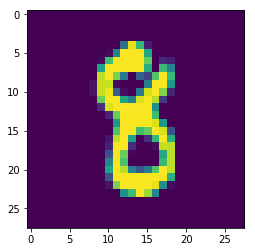

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

number = mnist.train.next_batch(1)[0]

plt.imshow(number.reshape(28,28))

Make sure that our model can efficiently predict it: 

*This example works 99% of the time! ;-)*

In [5]:
sess.run(pred,feed_dict={x: number})[0]

8

Now we want to save this model, and serve it with TensorFlow Serving. We define the path where we store the weights and the model version.

*Please note that you would need to increment `VERSION` number and re-create your graph (restart this notebook) if you want to save another model.*

In [6]:
EXPORT_PATH = "/tmp/models"
VERSION=1

And here we are saving the actual weights. 

In [7]:
from tensorflow.contrib.session_bundle import exporter

saver = tf.train.Saver(sharded=True)
model_exporter = exporter.Exporter(saver)
model_exporter.init(
    sess.graph.as_graph_def(),
    named_graph_signatures={
        'inputs': exporter.generic_signature({'x': x}),
        'outputs': exporter.generic_signature({'pred': pred})})
model_exporter.export(EXPORT_PATH, tf.constant(VERSION), sess)

INFO:tensorflow:/tmp/models/00000001-tmp/export is not in all_model_checkpoint_paths. Manually adding it.


'/tmp/models/00000001'

Let's make sure the weights were saved correctly

In [8]:
!ls -lhR /tmp/models

/tmp/models:
total 12K
drwxr-xr-x 2 root root 4.0K Mar 10 10:29 00000001
-rw-r--r-- 1 root root 7.6K Mar 10 10:29 model.log

/tmp/models/00000001:
total 72K
-rw-r--r-- 1 root root 119 Mar 10 10:29 checkpoint
-rw-r--r-- 1 root root 31K Mar 10 10:29 export.data-00000-of-00001
-rw-r--r-- 1 root root 159 Mar 10 10:29 export.index
-rw-r--r-- 1 root root 29K Mar 10 10:29 export.meta


## Services
When this Docker Image started, it run `example_jupyter/setup.sh`. It started following services:


- `jupyter notebook`

This is jupyter notebook which we are using right now.


- `/serving/bazel-bin/tensorflow_serving/model_servers/tensorflow_model_server`

This is TF Model Server running. It came as a part of TF-Serving standard distribution. It serves models using gRPC protocol.


- `/serving/bazel-bin/tensorflow_serving/example/flask_client`

I've added this Flask application to convert REST requests into gPRC requests. Perhaps this takes away from speed, but at least it's clear what is going on - you can find the code here: `tensorflow_serving/example/flask_client.py`.

Let's check TF Model Server. Until now it waited idly for a model to appear in that folder.
 We can now check the logs to make sure it recognised and loaded the model we just saved:

In [9]:
!tail -n2 /tmp/models/model.log

2017-03-10 10:29:49.461339: I tensorflow_serving/core/loader_harness.cc:86] Successfully loaded servable version {name: default version: 1}
2017-03-10 10:29:49.464518: I tensorflow_serving/model_servers/main.cc:257] Running ModelServer at 0.0.0.0:9000 ...


## REST request
*Following part can run independently from what happened before - so you can run it in a different notebook, or on even on the host machine.*

Here's an example of a function we can use to query our model via REST.

In [10]:
import numpy as np
import cPickle as pickle
import requests

def test_flask_client(x):
    URL = "http://localhost:8915/model_prediction"

    s = pickle.dumps({"x":x}, protocol=0)

    DATA = {"model_name": "default",
            "input": requests.utils.quote(s)}

    r = requests.get(URL, data=DATA)
    return r.json()

Let's make sure our train data still makes sense:

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


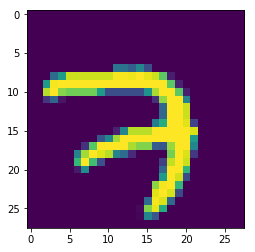

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
number = mnist.train.next_batch(1)[0]

plt.imshow(number.reshape(28,28))

## Running prediction
And finally - let's run a prediction on TensorFlow Serving!

In [12]:
test_flask_client(number)

{u'outputs': {u'pred': {u'dtype': u'DT_INT64',
   u'int64Val': [u'7'],
   u'tensorShape': {u'dim': [{u'size': u'1'}]}}}}

It's easy to extract the actual prediction value from here

In [13]:
int(test_flask_client(number)["outputs"]["pred"]["int64Val"][0])

7

## Done!

And that's it! Now you got Docker Container which is running you TensorFlow model with Tensorflow Serving. This model can be queried via `REST` (as we just did), or via `gRPC` (port 9000).

It is easy to export this as Docker Image so that it can be run elsewhere. In your host console do the following:

`docker ps`

It will show the ID of your running container. Use it in the following command (replace *XXXXXX* with *CONTAINER ID*)

`docker commit XXXXXX  my_name/my_model:version1`

`docker save my_name/my_model:version1 > my_name.my_model.version1.tar`

Now your Docker image (with the model inside) is saved into a `tar` file, which you can easily move around. (I'm not suggesting that this is best practice, but it works). Once you got it to the server, do the following to run it:

`docker load --input my_name.my_model.version1.tar`

`docker run --rm -it -p 8888:8888 -p 9000:9000 -p 8915:8915  my_name/my_model:version1`

And now you got your model running on a new server! Hope this works for you!